# **Projet de Processus de Poisson :** Thinning Algorithms for Simulating Point Processes

La méthode du **thinning** permet de simplifier la représentation spatiale de données en sélectionnant certains points vérifiant une condition donnée, tout en préservant les caractéristiques importantes de ces données. C'est une généralisation de la méthode d'acceptation/rejet souvent utilisée pour générer des variables aléatoires. La méthode du thinning permet de créer un processus de Poisson non homogène en sélectionnant judicieusement des points à partir d'un processus de Poisson homogène.

In [1]:
#! pip install -U Cython numpy
#! pip install hawkeslib

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import math
import pandas as pd
from scipy.stats import kstest
import statsmodels.api as sm
from hawkeslib import UnivariateExpHawkesProcess as UVHP
from datetime import datetime

## **Processus de comptage et processus ponctuel**

Pour commencer, nous définissons dans cette partie les processus de comptage et les processus ponctuels. En effet, ces deux derniers sont utilisés pour définir les processus de Poissons et de Hawkes, qui nous intéressent dans ce projet.

**Définition:** Le processus N(t) de comptage compte le nombre d'événements qui arrivent dans l'intervalle de temps $[0,t]$. Il  est défini par le processus $\{N(t) ; t \geq 0\}$ et vérifie les propriétés suivantes : 
- $\forall t \geq 0$, $N(t)$ est constant par morceaux et à valeurs dans $\mathbb{N}$ ;
- $t \mapsto N(t) \text{ est croissante}$ ;
- $\forall 0<a<b$, $N(b)-N(a)$ représente le nombre d'événements arrivant dans l'intervalle de temps $]a,b]$.


**Définition:** Un processus ponctuel sur $\mathbb{R}^+$ est un sous-ensemble aléatoire et dénombrable de $\mathbb{R}^+$ où chaque point correspond au moment d'occurance d'événement. Il est aussi défini comme l'intersection entre $\mathbb{R}^+$ et la séquence croissante des temps auxquels les événements se produisent. Cette séquence est aussi appelée comme l'ensemble des temps d'arrivée et notée $0 < T_1 < T_2 < ... < T_n < ...$ avec  $(T_n)_n \in \mathbb{R}^+$ 

**Lien entre processus ponctuel $(T_n)_n$ et processus de comptage $(N_t)_t$:**   
$ \forall n \in \mathbb{N}^+$ et pour tout ($t_1$, $t_2$, ..., $t_n$) dans $\mathbb{R}^+$ : 

$ \{T_1 \leq t_1, T_2 \leq t_2, \ldots, T_n \leq t_n \} = \{ N_{t_1} \geq 1, N_{t_2} \geq 2, \ldots, N_{t_n} \geq n \}$

Il est donc équivalent de définir un processus ponctuel grâce aux temps d'arrivée ou grâce au processus de comptage. On choisira pour la suite de le définir avec $(N_t)_t$.

***Propriété :*** Un processus de ponctuel N est à *accroissements indépendants* si le nombre de points entre intervalles disjoints est indépendant. Autrement dit, $\forall n \in \mathbb{N}^*$, $\forall \quad  0<t_1<t_2<...<t_n$, les variables aléatoires $N_{t_1}-N_0, N_{t_2}-N_{t_1}, ..., N_{t_n}-N_{t_{n-1}}$ sont indépendantes.



***Propriété:*** Un processus ponctuel est à *accroissements stationnaires* si la distribution du nombre de points de tout intervalle de temps dépend uniquement de la longueur de cet intervalle. Autrement dit, $\forall s \geq 0$, le nombre de points dans l'intervalle $(t,s+t]$ soit $N_{t+s}-N_{t}$ a la même distribution $\forall t$.

## **Processus de poisson homogène sur $\mathbb{R}_+$**

Dans cette partie, nous donnons quelques définitions et propriétés des processus de Poisson homogènes avant de les simuler !

**Définition :** Un processus de ponctuel $\{N(t) ; t \geq 0\}$ est appelé processus de Poisson homogène d'intensité $\lambda > 0$ si :
- $N(0) = 0$ ; 
- Le processus est à accroissements indépendants et stationnaires;
- $\mathbb{P}(N_{t+h} - N_t = 1) = \lambda h + o(h)$;
- $\mathbb{P}(N_{t+h} - N_t > 1) = o(h)$.

***Proposition:*** Le nombre de points dans un intervalle de longueur t d'un processus de poisson homogène suit une loi de Poisson de paramètre $\lambda t$. 
$$ \mathbb{P}\{N(t + s) - N(s) = n \} = e^{-\lambda t}\frac{{(\lambda t)^n }}{{n!}}$$

***Proposition:*** Les temps d'arrivée d'un processus de poisson homogène sont distribués suivant une variable aléatoire qui suit une loi exponentielle de paramètre $\lambda$.

***Proposition:***  $\mathbb{E}(N_t)=Var(N_t)= \lambda t$

### *Algo 1: Simulation d'un processus de Poisson Homogène avec un taux λ sur [0,T]*

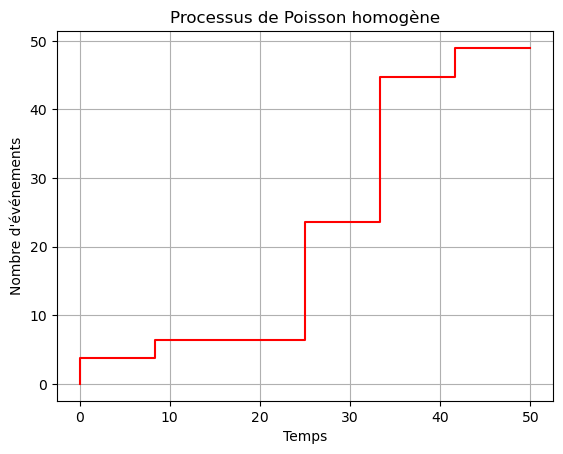

In [3]:
def Process_homogène(lamb,T):
    val=[0]
    t=0
    while True :
        u=npr.uniform(0,1)
        w=-1/lamb * np.log(u)## w~exp(lamb)
        #print(w)
        t=t+w
        #print(times)
        if t > T : 
            return val, len(val)
        else : 
            val.append(t)

#On simule un Poisson Homogène avec notre "Algo 1"
lamb = 0.1
T = 50
P,n= Process_homogène(lamb,T)

times=np.linspace(0,T,n) #création intervalle de temps

#Affichage
plt.step(times, P,color='red')
plt.xlabel('Temps')
plt.ylabel('Nombre d\'événements')
plt.title('Processus de Poisson homogène')
plt.grid(True)
plt.show()

## **Processus de poisson inhomogène sur $\mathbb{R}_+$**

Dans cette partie, nous définissions désormais les processus de poisson inhomogène avant d'également les simuler !

**Définition :** Un processus de ponctuel $\{N(t) ; t \geq 0\}$ est appelé processus de Poisson inhomogène avec pour intensité la fonction localement intégrable $\lambda (t) > 0$, $t>0$ si :
- $N(0) = 0$ ; 
- Le processus est à accroissements indépendants et stationnaires;
- $\mathbb{P}(N_{t+h} - N_t = 1) = \lambda(t) h + o(h)$;
- $\mathbb{P}(N_{t+h} - N_t > 1) = o(h)$.

La fonction $\Lambda$ : $t \mapsto \int_{0}^{t} \lambda (s) \,ds $ est appelée l'intensité cumulée du processus de Poisson inhomogène. 

La définition précédente est identique à celle d'un processus de Poisson homogène à la différence que l'intensité n'est maintenant plus constante, mais dépend du temps $t$.

***Proposition :*** Un processus de Poisson inhomogène N d'intensité la fonction $\lambda (t)$ suit une loi de Poisson de paramètre $\int_{0}^{t}\lambda (s) \,ds$ : 

$$\mathbb{P}(N(t)=n) = \frac{\exp^{-\int_{0}^{t}\lambda (s) \,ds} (\int_{0}^{t}\lambda (s) \,ds)^n} {n!} $$

***Proposition:***  $\mathbb{E}(N_t)=Var(N_t)=\Lambda(t)$

### *Algo 2: Simulation d'un processus de Poisson Inhomogène avec une fonction intensité bornée sur [0,T]*

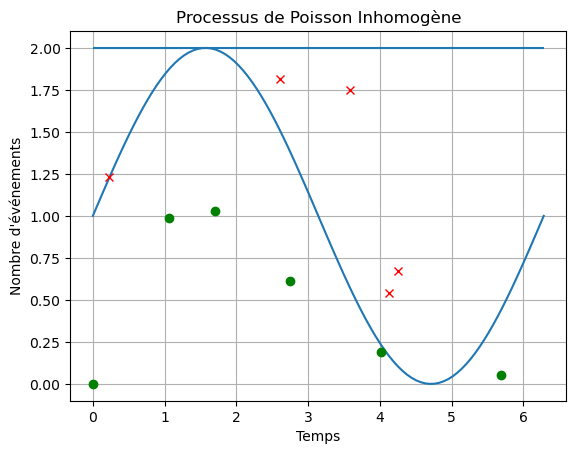

In [4]:
lamb = 0.4
Tmax = 2*np.pi
times=np.linspace(0,Tmax, 10)

#### fonction densité ####
def lambd(t) :
    return 1+np.sin(t)

#### fonction qui calcule le sup ####
def sup(fonction, debut=0, fin=Tmax, pas=0.01):
    t = debut
    sup = fonction(debut)
    while t <= fin: 
        if fonction(t) > sup:
            sup = fonction(t)
        t += pas
    return sup

 
#### fonction qui génère le process ####
def Process_inhomogène(lamb,Tmax):
    T=[0] ; S=[0]
    T_R=[] ; R=[]
    t=0 ; s=0
    lamb_max= sup(lamb)
    
    while s<Tmax :
        u=npr.uniform(0,1)
        w=-math.log(u)/lamb_max    # w~exp(lamb_max)
        s=s+w
        D=npr.uniform(0,1)
        if D <= lamb(s)/lamb_max : #condition d'acception des temps tau par rapport au sup de notre fonction lambda 
            t=s
            T.append(t)            #tau accepté
            S.append(D*lamb_max)   #valeur de D*lamdba_max pour les tau acceptés
        else :
            T_R.append(s)                                                                                                                                       #Lise refusée
            R.append(D*lamb_max)   #valeur de D*lamdba_max pour les tau refusés
            t=s                    #pour bien s'assurer qu'on ne dépasse pas tmax même dans ce cas où on incrément pas les tau acceptés 
    if t<=Tmax :
        return T,S,T_R,R
    else : 
        return T[:-1],S[:-1],T_R[:-1],R[:-1] #on renvoie tous les points sauf le dernier élémént qui est supérieur à Tmax
        
                                        
     
x=np.linspace(0,Tmax,100)
#Application de la fonction rate: 
plt.plot(x, lambd(x))
plt.hlines(2,0,Tmax)



#Applications de la fonction de simulation/thinning
T,D,T_R,R= Process_inhomogène(lambd,Tmax)

plt.plot(T,D, "o",color='green')
plt.plot(T_R,R, "x",color='red')
plt.xlabel('Temps')
plt.ylabel('Nombre d\'événements')
plt.title('Processus de Poisson Inhomogène')
plt.grid(True)
plt.show()

## **Processus de Hawkes sur $\mathbb{R}_+$**

**Définition :** Un processus est dit simple si 
$$ P(N({t}) = 0 \text{ ou } 1 \text{ pour tout } t) = 1 $$


**Définition** : (Hawkes, 1971) Un processus de Hawkes est un processus ponctuel univariant simple N(t) qui vérifie : 
- N(t) = 0 ;
- λ(t) est processus stochastique continu à gauche, donné par l'intégrale de Stieltjes :
$$ \lambda(t) = \mu + \int_{0}^{t} \alpha \exp(-\beta (t-s)) \, dN(s) = \mu + \sum_{k: t_k < t} \alpha \exp^{-\beta (t-s)} $$
avec $\mu>0$ et $0 < \alpha < \beta$ ;
- λ(t) est l'intensité stochastique du processus de ponctuel telle que :  
$$ P(N(t+h) - N(t) = 1 \,|\, \mathcal{F}_{t^-}^N) = \lambda(t)h + o(h) $$ 
- Le processus de ponctuel est ordonné tel que : 
$$ P(N(t+h) - N(t) \geq 2 \,|\, \mathcal{F}_{t^-}^N) = o(h) $$

Ce processus est dit Hawkes univariant avec une décroissance exponentielle sur $[0,\inf)$.




### Algo 3: Simulation of a Univariate Hawkes Poisson with Exponential Kernel

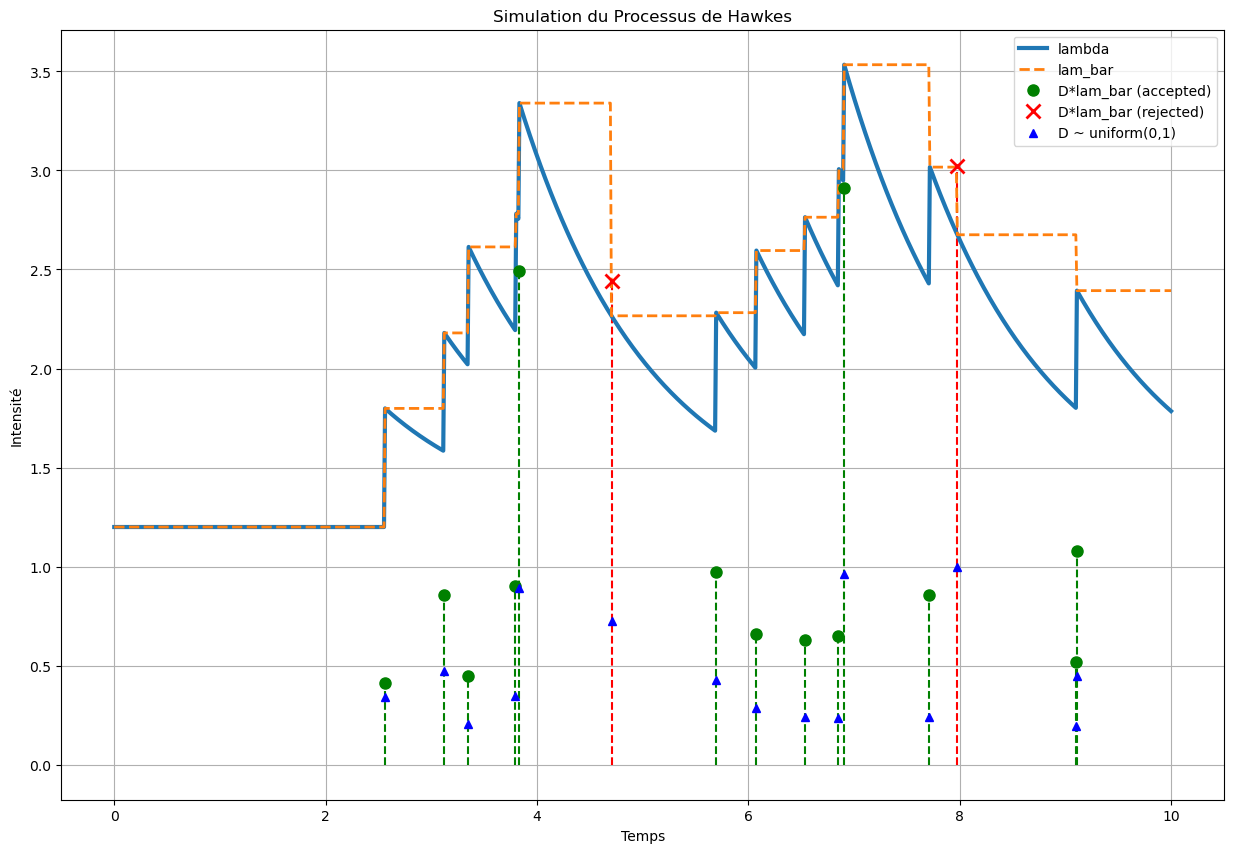

In [5]:
# fonction densité ####
def lam(su,times,mu=1.2,alpha=0.6,beta=0.8) :
    if times == []:
        return mu
    else : 
        return mu + np.sum(alpha * np.exp(-beta * (su - np.array(times))))    


def Hawkes_Process(mu, alpha, beta, Tmax):
    T = []  # Pour stocker les tau
    S = [] # Pour stocker le critère d'accepttaion du tau
    s = 0  # Initialize s
    T_R = [] ; R = []
    L = [] ; I = []
    while s < Tmax:
        if T == []:
            lambda_bar = mu
            L.append(lambda_bar)
        u = np.random.uniform(0, 1)
        w = -np.log(u)/lambda_bar
        s += w
        D = np.random.uniform(0, 1)
        I.append(D)
        l=lam(s,T)
        if D * lambda_bar <= l:
            t=s
            T.append(t)              #tau accepté
            S.append(D*lambda_bar)   #valeur de D*lamdba_max pour les tau acceptés
            lambda_bar= mu + alpha * np.sum(np.exp(-beta * (s - np.array(T))))
        else :
            T_R.append(s)                                                                                                                                       #Lise refusée
            R.append(D*lambda_bar)   #valeur de D*lamdba_max pour les tau refusés
            t=s                    #pour bien s'assurer qu'on ne dépasse pas tmax même dans ce cas où on incrément pas les tau acceptés
            lambda_bar= mu + alpha * np.sum(np.exp(-beta * (s - np.array(T))))
    plt.show()
    if t<=Tmax :
        return T,S,T_R,R,I
    else :
        return T[:-1],S[:-1],T_R[:-1],R[:-1], I[:-2] #on renvoie tous les points sauf le dernier élémént qui est supérieur à Tmax

# Application:
mu = 1.2
alpha = 0.6
beta = 0.8
Tmax = 10
TH,DH,TH_R,RH, D= Hawkes_Process(mu, alpha, beta, Tmax)

#Application de la fonction rate:
times=np.linspace(0,Tmax,1000)
l=[] ; sup_l = []; brk2 = []
j=0; count =0
for i in times:
    count +=1
    if j < len(TH)-1:
        if i < TH[0]:
            temp = mu
        elif i < TH[j]:
            temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH[:j]))))
        else :
            brk2.append(count-1)
            j=j+1
            temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH[:j]))))
        l.append(temp)
    else:
        temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH[:-1]))))
        l.append(temp)


        
#Affichage du lambda max
brk=[]
b=0
j=0
i=0

int_array = [int(x*100) for x in TH_R]
brk=brk2+int_array
brk=sorted(brk)

for j in range(len(brk)):
    while i < brk[j]:
        sup_l.append(max(l[b:brk[j]]))
        i+=1
    b=brk[j]
    j+=1
while i < len(l):
    sup_l.append(max(l[brk[-1]:len(l)-1]))
    i+=1


fig = plt.figure(figsize = (15, 10))


count=0
for i in TH:
    if count < len(DH):
        plt.plot([i, i], [0, DH[count]], 'g--')
        count+=1
    #plt.axvline(x=i, linestyle='--', color='green', linewidth=1)
count=0
for j in TH_R:
    if count < len(RH):
        plt.plot([j, j], [0, RH[count]], 'r--')
        count+=1
    #plt.axvline(x=j, linestyle='--', color='red', linewidth=1)

plt.plot(times, l,label="lambda", linewidth=3)
plt.plot(times, sup_l, linestyle='--', label="lam_bar",linewidth=2)

plt.plot(TH,DH, "o",color='green', markersize=8, label="D*lam_bar (accepted)")
plt.plot(TH_R,RH, "x",color='red', markersize=10, markeredgewidth=2, label="D*lam_bar (rejected)")
TH2=TH+TH_R
TH2=sorted(TH2)

plt.plot(TH2, D,"^",color='blue', markersize=6, label="D ~ uniform(0,1)")
plt.xlabel('Temps')
plt.ylabel('Intensité')
plt.title('Simulation du Processus de Hawkes')
plt.legend()
plt.grid(True)
plt.show()

## **Cas pratique : Application de l'algo de Hawkes aux données financières du CAC40**

In [31]:
#Chargement des données
CAC40 = pd.read_csv('^FCHI.csv')
#CAC40 = pd.read_csv('^FCHI(1).csv')
display(CAC40)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-05-15,7443.379883,7455.629883,7397.859863,7418.209961,7418.209961,48638700
1,2023-05-16,7394.850098,7427.569824,7377.810059,7406.009766,7406.009766,61261800
2,2023-05-17,7378.830078,7422.580078,7354.540039,7399.439941,7399.439941,57783800
3,2023-05-18,7440.750000,7481.779785,7426.390137,7446.890137,7446.890137,59991600
4,2023-05-19,7469.779785,7523.560059,7463.959961,7491.959961,7491.959961,67973200
...,...,...,...,...,...,...,...
251,2024-05-08,8093.620117,8157.479980,8089.279785,8131.410156,8131.410156,53988400
252,2024-05-09,8123.919922,8191.919922,8114.879883,8187.649902,8187.649902,39071500
253,2024-05-10,8232.650391,8259.190430,8211.200195,8219.139648,8219.139648,57091000
254,2024-05-13,8211.070313,8223.809570,8186.770020,8209.280273,8209.280273,48113100


In [32]:
## regarder date d'ouverture marché et de fermeture 
## abs(close-open) / close > seuil (1%) #le rendement permet d'avoir une mesure à peu près homogène
## on compte le nombre de fois où ça arrive et a chaque fois que ca arrive on le stocke
## faire repartition dans le vecteur temps avec histogramme  et le vecteur est censé représenté une loi exponentielle

### Processus de Comptage

['2023-05-23', '2023-06-02', '2023-06-05', '2023-06-16', '2023-07-06', '2023-07-12', '2023-07-20', '2023-07-27', '2023-08-15', '2023-08-24', '2023-09-14', '2023-09-18', '2023-10-02', '2023-10-10', '2023-10-12', '2023-10-13', '2023-10-27', '2023-11-08', '2023-11-14', '2023-12-08', '2024-01-03', '2024-01-11', '2024-01-19', '2024-01-26', '2024-03-07', '2024-04-12', '2024-04-30']


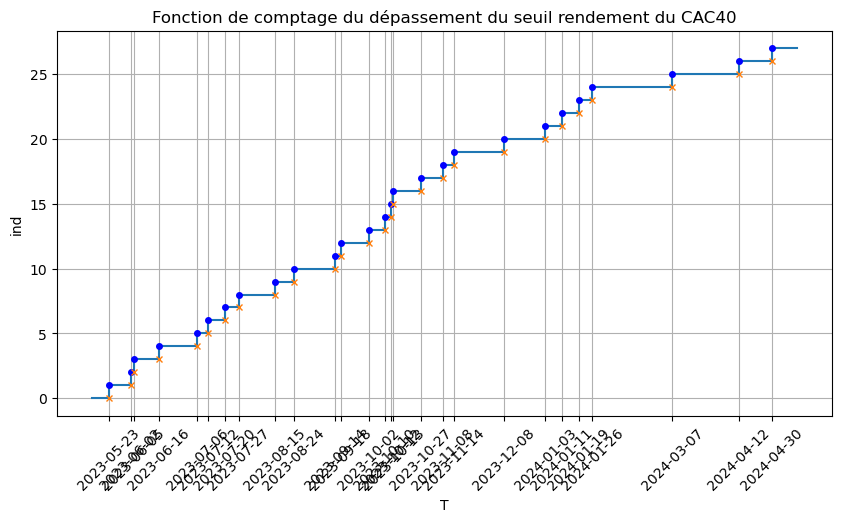

[19499.916666666668, 19509.916666666668, 19512.916666666668, 19523.916666666668, 19543.916666666668, 19549.916666666668, 19557.916666666668, 19564.916666666668, 19583.916666666668, 19592.916666666668, 19613.916666666668, 19617.916666666668, 19631.916666666668, 19639.916666666668, 19641.916666666668, 19642.916666666668, 19656.916666666668, 19668.958333333332, 19674.958333333332, 19698.958333333332, 19724.958333333332, 19732.958333333332, 19740.958333333332, 19747.958333333332, 19788.958333333332, 19824.916666666668, 19842.916666666668]


In [57]:
#display(CAC40.iloc[:,1]) 2eme colonne 
ferme = CAC40.iloc[:,4]
ouvert = CAC40.iloc[:,1]
date = CAC40.iloc[:,0]

T=[]
T_last=[]
Val=[]
ind_seuil=[]
ind_1=[]; ind_2=[]
ind=0
a=0
for i in range(len(CAC40)): 
    if np.abs(ferme[i] - ouvert[i]) / ferme[i] > 0.01 :
        T.append(date[i]) #à chaque fois que l'expression dépasse le seuil on stocke la date 
        Val.append(np.abs(ferme[i] - ouvert[i]) / ferme[i]) #on stocke également la valeur du taux
        ind+=1
        ind_seuil.append(ind) #on stocke l'index
        ind_1.append(ind)
        ind_2.append(ind-1)
    else :
        ind_seuil.append(ind)
        
        
# Filtrer les données
x_filtered = date[ind_1]

fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(date, ind_seuil, drawstyle='steps-post')
plt.plot(T, ind_1, "o", color="blue", markersize=4)
plt.plot(T, ind_2, "x", markersize=4, label='T')
print(T)
plt.xlabel('T')
ax.set_xticks(T)
ax.set_xticklabels(T, rotation=45)
plt.ylabel('ind')
plt.title('Fonction de comptage du dépassement du seuil rendement du CAC40')
plt.grid(True)
plt.show()

# Fonction pour convertir une date en float
def date_to_float(date_str):
    # Conversion de la chaîne de caractères en objet datetime
    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
    # Conversion de la date en timestamp (secondes depuis l'époque Unix)
    timestamp = date_obj.timestamp()
    # Vous pouvez ensuite diviser par le nombre de secondes par jour si vous voulez un float en jours
    return timestamp / (24 * 3600)

# Conversion de la liste de dates en une liste de floats
float_dates = [date_to_float(date) for date in T]

print(float_dates)

### Test de Kolmogorov Smirnoff Lilifors
On veut désormais tester s'il existe un paramètre tel que le processus de comptage ci-dessus peut être assimilé à un processus de poisson homogène. Ainsi on teste si les inter-sauts quivent une loi exponentielle dont on ne connaît pas le paramètre. 

Ainsi on doit faire un test de Kolmogorov Smirnoff corrigé par Lilifors sur ces inter-sauts.

In [9]:
#print(T)
inter_saut=[]
for i in range(0,len(T)-1):
    inter_saut.append(float_dates[i+1]-float_dates[i])
    
#print(inter_saut)
#Test d'ajustement (Kolmogorov Smirnoff Lilifors)
ksstat, pvalue = sm.stats.diagnostic.lilliefors(inter_saut,"exp",'approx')
print("La stat de test est :",ksstat)
print("La p_value du test est ", pvalue)

alpha=0.05
if pvalue > alpha:
    result = 'Inter-Saut Exponentiel => Processus de Poisson Homogène'
else:
    result = 'Inter-Saut non exponentiel => Pas un Processus de Poisson Homogène'
print(f'Lilliefors: {result:>21s}')

La stat de test est : 0.1606878870993071
La p_value du test est  0.0009999999999998899
Lilliefors: Inter-Saut non exponentiel => Pas un Processus de Poisson Homogène


### **Hawkeslib** pour un Poisson Homogène

In [10]:
#ON simule un Poisson Homogène avec notre "Algo 1"
lamb = 0.1
T = 50
P,n= Process_homogène(lamb,T)

In [11]:
from hawkeslib import UnivariateExpHawkesProcess as UVHP
uv = UVHP()
uv.fit(np.array(P))

-15.520148351022964

In [12]:
# verify that the unconditional mean makes sense
mu, alpha, beta = uv.get_params()

N_approx = mu * P[-1] / (1 - alpha)

print(N_approx)
print(len(P))
print("alpha:",alpha)
print("mu:",mu)
print("beta:",beta)

5.0035986515165565
5
alpha: 0.0007674482412607934
mu: 0.12195948406995963
beta: 0.00160544346492221


**Rq :** Le alpha est toujours très proche de 0 donc on a bien ce à quoi on s'attendait en passant un poisson homogène dans l'estimation des coefficient d'un Hawkes, car le terme de décroissance exponentielle est très fortement réduit car il est multiplié par alpha dans un Hawkes donc avec un alpha dans l'ordre de grandeur de 10^-3 on a bien une atténuation de la décroissane exp du lambda

### **Hawkeslib** pour un Hawkes

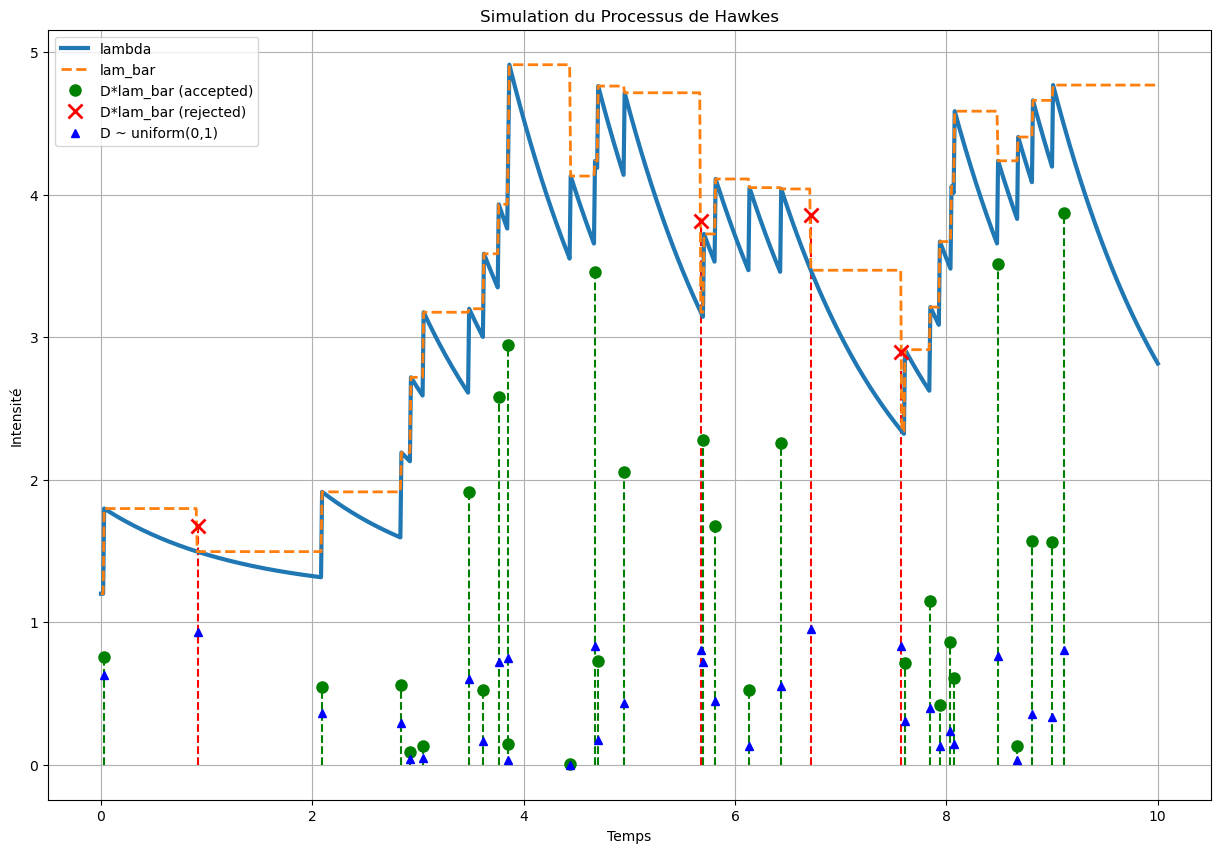

In [13]:
# Application:
mu = 1.2
alpha = 0.6
beta = 0.8
Tmax = 10
TH,DH,TH_R,RH, D= Hawkes_Process(mu, alpha, beta, Tmax)

#Application de la fonction rate:
times=np.linspace(0,Tmax,1000)
l=[] ; sup_l = []; brk2 = []
j=0; count =0
for i in times:
    count +=1
    if j < len(TH)-1:
        if i < TH[0]:
            temp = mu
        elif i < TH[j]:
            temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH[:j]))))
        else :
            brk2.append(count-1)
            j=j+1
            temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH[:j]))))
        l.append(temp)
    else:
        temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH[:-1]))))
        l.append(temp)


        
#Affichage du lambda max
brk=[]
b=0
j=0
i=0

int_array = [int(x*100) for x in TH_R]
brk=brk2+int_array
brk=sorted(brk)

for j in range(len(brk)):
    while i < brk[j]:
        sup_l.append(max(l[b:brk[j]]))
        i+=1
    b=brk[j]
    j+=1
while i < len(l):
    sup_l.append(max(l[brk[-1]:len(l)-1]))
    i+=1


fig = plt.figure(figsize = (15, 10))


count=0
for i in TH:
    if count < len(DH):
        plt.plot([i, i], [0, DH[count]], 'g--')
        count+=1
    #plt.axvline(x=i, linestyle='--', color='green', linewidth=1)
count=0
for j in TH_R:
    if count < len(RH):
        plt.plot([j, j], [0, RH[count]], 'r--')
        count+=1
    #plt.axvline(x=j, linestyle='--', color='red', linewidth=1)

plt.plot(times, l,label="lambda", linewidth=3)
plt.plot(times, sup_l, linestyle='--', label="lam_bar",linewidth=2)

plt.plot(TH,DH, "o",color='green', markersize=8, label="D*lam_bar (accepted)")
plt.plot(TH_R,RH, "x",color='red', markersize=10, markeredgewidth=2, label="D*lam_bar (rejected)")
TH2=TH+TH_R
TH2=sorted(TH2)

plt.plot(TH2, D,"^",color='blue', markersize=6, label="D ~ uniform(0,1)")
plt.xlabel('Temps')
plt.ylabel('Intensité')
plt.title('Simulation du Processus de Hawkes')
plt.legend()
plt.grid(True)
plt.show()

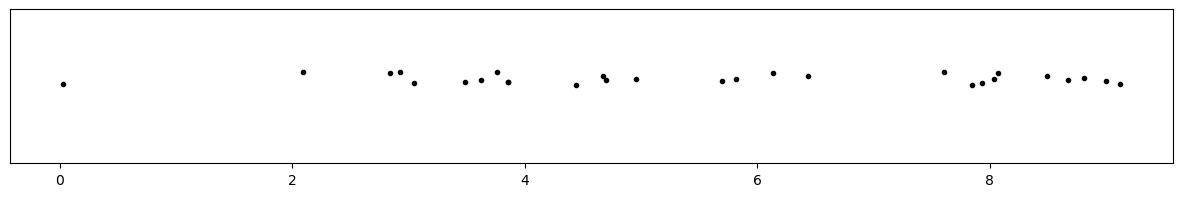

In [14]:
plt.figure(figsize=(15,2))
plt.ylim([-5, 5])
plt.yticks([])
_ = plt.plot(TH, np.random.rand(len(TH)), 'k.')

In [15]:
uv2 = UVHP()
#uv2.set_params(1.2,0.6,0.8)
uv2.fit(np.array(TH))
print(TH[-1])

9.116536482307291


In [16]:
# verify that the unconditional mean makes sense
mu, alpha, beta = uv2.get_params()

N_approx = mu * TH[-1] / (1 - alpha)

print(N_approx)
print(len(TH))
print("alpha:",alpha)
print("mu:",mu)
print("beta:",beta)

-12.390657367866217
28
alpha: 2.2171378573142277
mu: 1.6542618118961963
beta: 0.0696567790288028


In [59]:
param_pairs = []
for j in range(20):
    # priors
    pars = np.random.gamma(3.), np.random.rand() * .3, 1/np.random.gamma(1.)

    hp = UVHP()
    hp.set_params(*pars)
    smp = hp.sample(10000, method="branching")
    
    # fit with gd
    hp2 = UVHP()
    hp2.fit(smp, method="gd")
    
    # fit with em
    hp3 = UVHP()
    hp3.fit(smp, method="em", reltol=1e-8)
    
    comb_pars = hp.get_params() + hp2.get_params() + hp3.get_params()
    param_pairs.append(comb_pars)

print(param_pairs[0])

(1.0582955045024514, 0.2362991413555171, 0.3103721670742927, 0.993980917456417, 0.28433012532786955, 0.24110098810401628, 1.0051452940916406, 0.2762843946975646, 0.2539731345387251)


[[1.05829550e+00 2.36299141e-01 3.10372167e-01 9.93980917e-01
  2.84330125e-01 2.41100988e-01 1.00514529e+00 2.76284395e-01
  2.53973135e-01]
 [1.32329595e+00 1.15748361e-01 7.48576465e-01 1.28960331e+00
  1.46231444e-01 7.82363498e-01 1.29202128e+00 1.44630160e-01
  7.96886454e-01]
 [1.95880651e+00 7.80921905e-02 2.87601474e+00 1.91276391e+00
  9.12182837e-02 2.92615451e+00 1.91179591e+00 9.16782458e-02
  2.90384517e+00]
 [2.21162750e+00 2.52311852e-01 1.48535972e+01 2.19181074e+00
  2.54143982e-01 1.42165812e+01 2.19162874e+00 2.54205821e-01
  1.42094034e+01]
 [4.07501252e+00 1.74607389e-01 4.52406747e-01 4.14457177e+00
  1.64878074e-01 4.06590721e-01 4.50489857e+00 9.22351349e-02
  1.10506198e+00]
 [8.18109112e-01 2.13520693e-01 1.96893320e+00 8.07668731e-01
  2.20388329e-01 1.86170775e+00 8.07222022e-01 2.20819516e-01
  1.85513216e+00]
 [2.74657207e+00 2.16873051e-01 2.65389661e+00 2.69499463e+00
  2.24879476e-01 2.43718151e+00 2.69709720e+00 2.24274588e-01
  2.44907548e+00]
 [5.84

Text(0, 0.5, 'Expectation-Maximization')

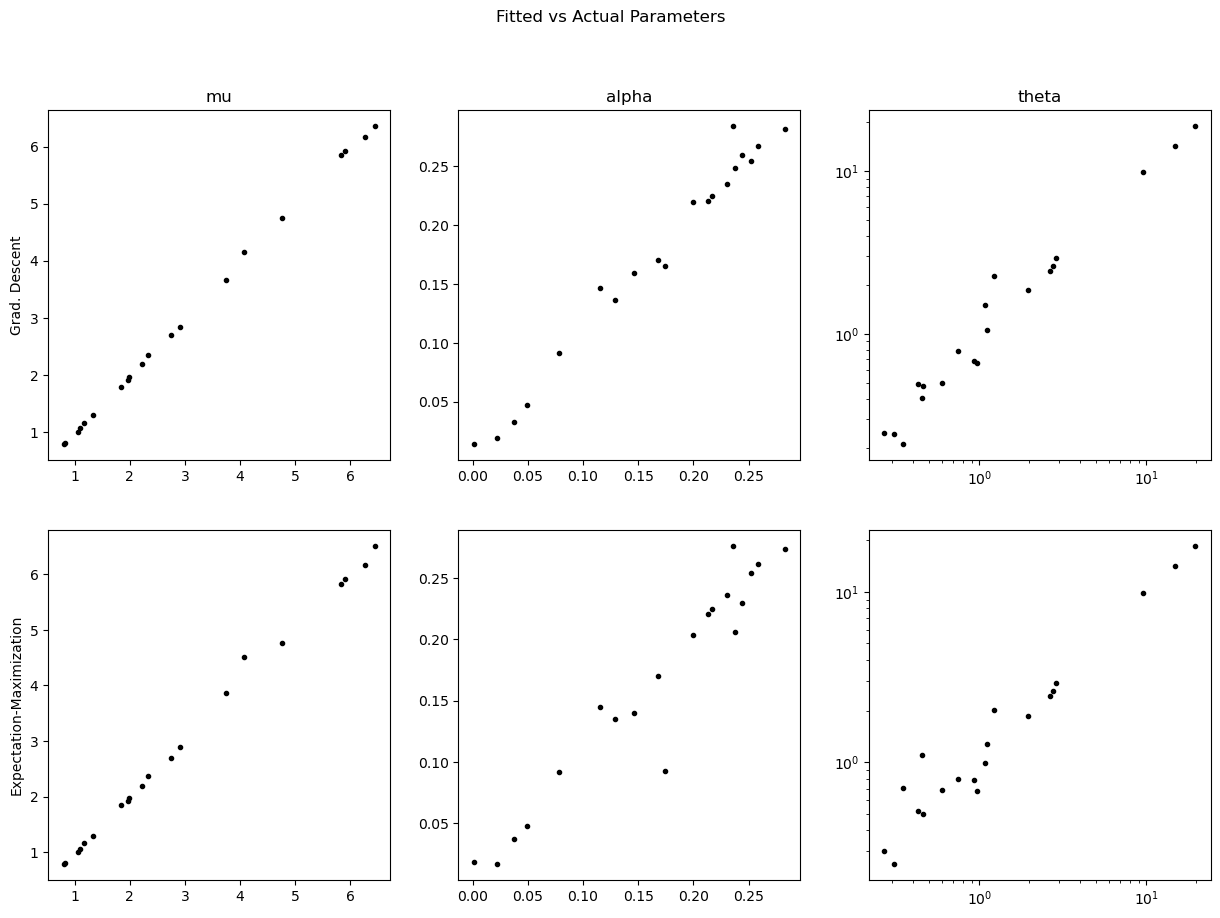

In [62]:
Z = np.array(param_pairs)
print(Z)

f, ax = plt.subplots(2, 3, figsize=(15,10))
f.suptitle("Fitted vs Actual Parameters")
for k in range(3):
    ax[0][k].plot(Z[:, k], Z[:, k+3], "k.")
    ax[0][k].set_title(["mu", "alpha", "theta"][k])
    
    ax[1][k].plot(Z[:, k], Z[:, k+6], "k.")

ax[0,2].loglog()
ax[1,2].loglog()

ax[0,0].set_ylabel("Grad. Descent")
ax[1,0].set_ylabel("Expectation-Maximization")

alpha: 0.993980917456417
mu: 1.0582955045024514
beta: 1.0051452940916406


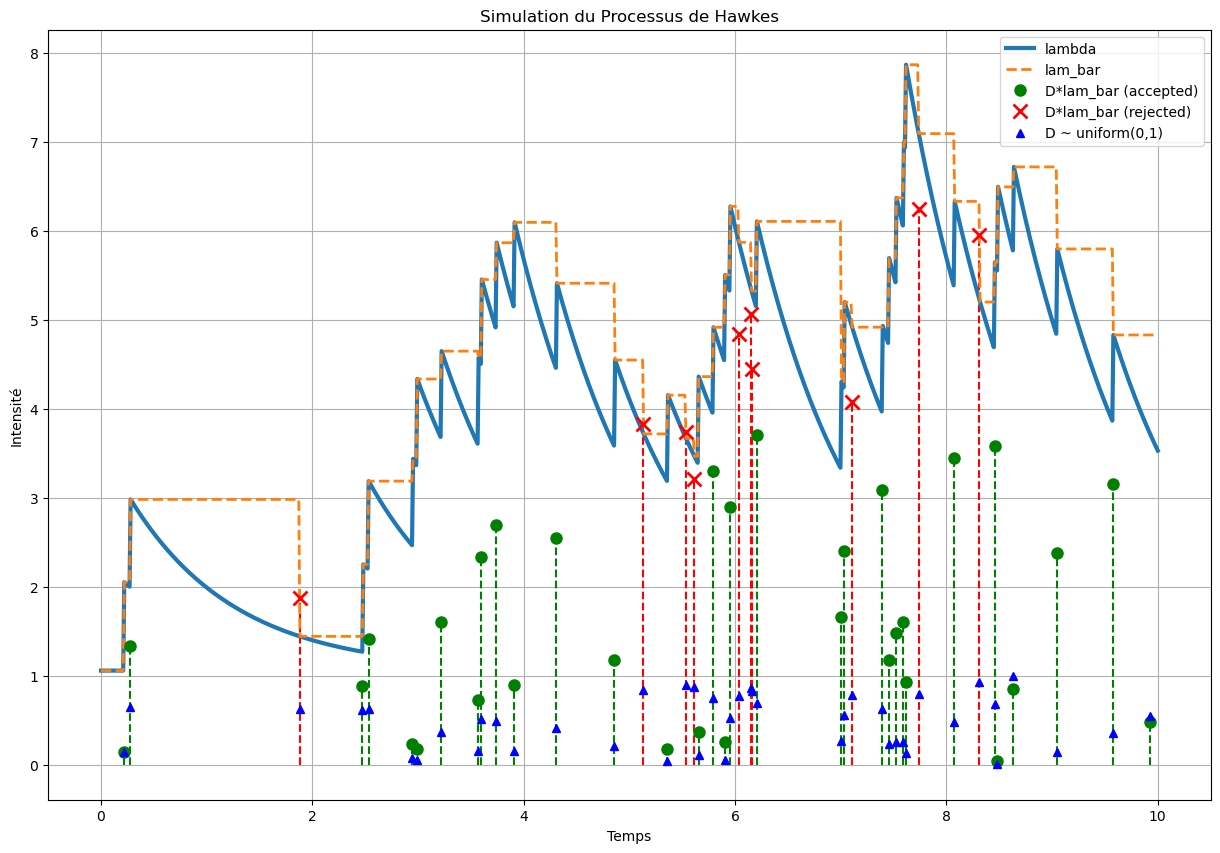

In [63]:
mu = Z[0,0]
alpha = Z[0,3]
beta = Z[0,6]

print("alpha:",alpha)
print("mu:",mu)
print("beta:",beta)
TH,DH,TH_R,RH, D= Hawkes_Process(mu, alpha, beta, Tmax)

#Application de la fonction rate:
times=np.linspace(0,Tmax,1000)
l=[] ; sup_l = []; brk2 = []
j=0; count =0
for i in times:
    count +=1
    if j < len(TH)-1:
        if i < TH[0]:
            temp = mu
        elif i < TH[j]:
            temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH[:j]))))
        else :
            brk2.append(count-1)
            j=j+1
            temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH[:j]))))
        l.append(temp)
    else:
        temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH[:-1]))))
        l.append(temp)


        
#Affichage du lambda max
brk=[]
b=0
j=0
i=0

int_array = [int(x*100) for x in TH_R]
brk=brk2+int_array
brk=sorted(brk)

for j in range(len(brk)):
    while i < brk[j]:
        sup_l.append(max(l[b:brk[j]]))
        i+=1
    b=brk[j]
    j+=1
while i < len(l):
    sup_l.append(max(l[brk[-1]:len(l)-1]))
    i+=1


fig = plt.figure(figsize = (15, 10))


count=0
for i in TH:
    if count < len(DH):
        plt.plot([i, i], [0, DH[count]], 'g--')
        count+=1
    #plt.axvline(x=i, linestyle='--', color='green', linewidth=1)
count=0
for j in TH_R:
    if count < len(RH):
        plt.plot([j, j], [0, RH[count]], 'r--')
        count+=1
    #plt.axvline(x=j, linestyle='--', color='red', linewidth=1)

plt.plot(times, l,label="lambda", linewidth=3)
plt.plot(times, sup_l, linestyle='--', label="lam_bar",linewidth=2)

plt.plot(TH,DH, "o",color='green', markersize=8, label="D*lam_bar (accepted)")
plt.plot(TH_R,RH, "x",color='red', markersize=10, markeredgewidth=2, label="D*lam_bar (rejected)")
TH2=TH+TH_R
TH2=sorted(TH2)

plt.plot(TH2, D,"^",color='blue', markersize=6, label="D ~ uniform(0,1)")
plt.xlabel('Temps')
plt.ylabel('Intensité')
plt.title('Simulation du Processus de Hawkes')
plt.legend()
plt.grid(True)
plt.show()

**Rq :** Le beta tend parfois vers +inf mais je sais pas trop trop pourquoi, c'est très aléatoire, et le mu et alpha sont assez bien approchés à chaque fois

### HAWKES POUR CAC40 OMG POG

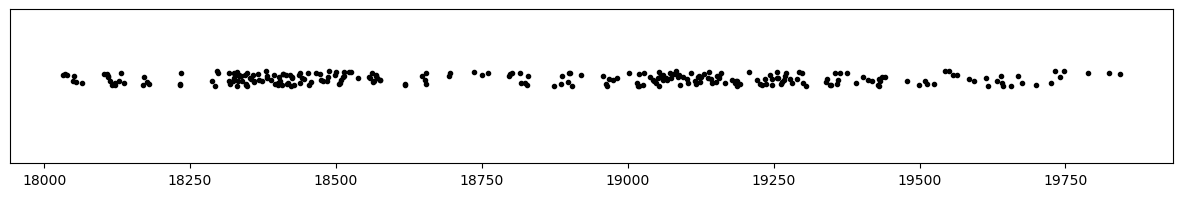

In [20]:
plt.figure(figsize=(15,2))
plt.ylim([-5, 5])
plt.yticks([])
_ = plt.plot(float_dates, np.random.rand(len(float_dates)), 'k.')

In [21]:
from hawkeslib import UnivariateExpHawkesProcess as UVHP
uv3 = UVHP()
uv3.fit(np.array(float_dates))

-772.975754380423

In [22]:
# verify that the unconditional mean makes sense
mu, alpha, beta = uv3.get_params()
#print(uv3.get_params())

N_approx = mu * float_dates[-1] / (1 - alpha)

print(N_approx)
print(len(float_dates))
print("mu:",mu)
print("alpha:",alpha)
print("beta:",beta)

-219.91062911749665
271
mu: 5.627507549576562e-05
alpha: 1.0050777974577856
beta: 0.022867043330142445


ValueError: x and y must have same first dimension, but have shapes (271,) and (10000,)

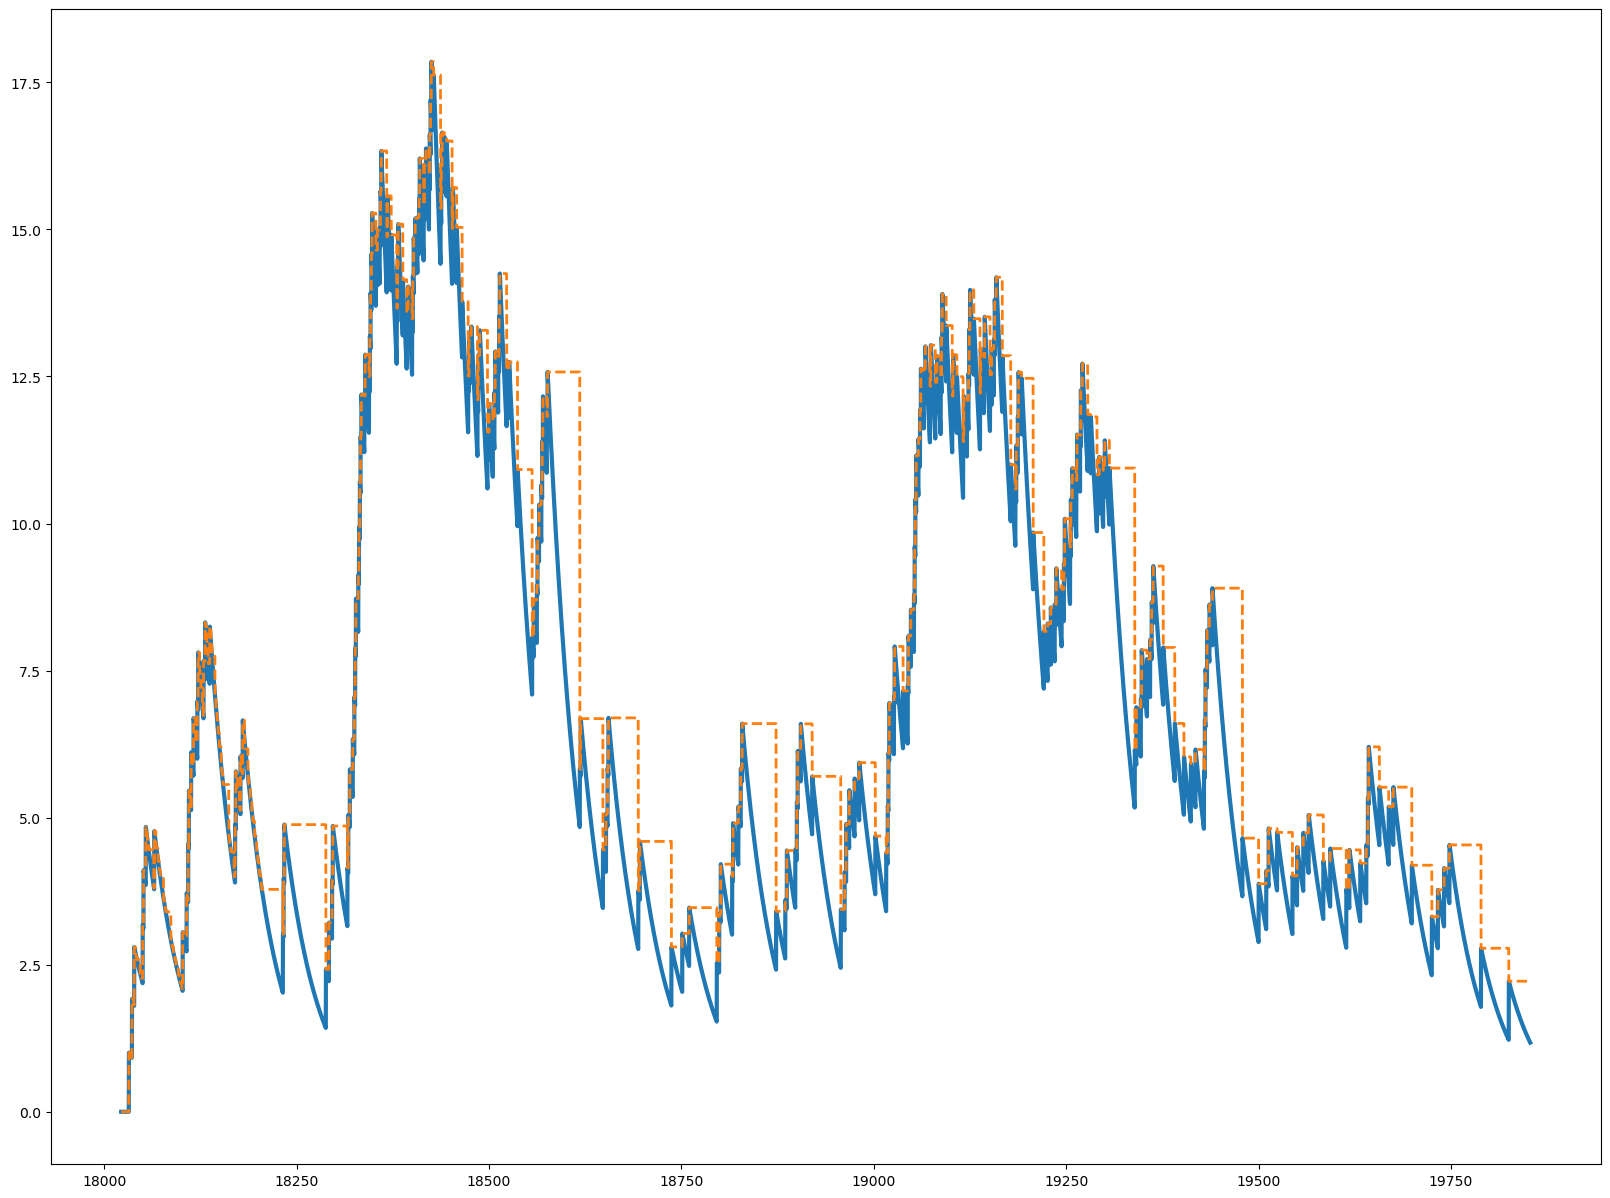

In [23]:
TH = float_dates
times=np.linspace(float_dates[0]-10,float_dates[-1]+10,10000)
l=[] ; sup_l = []; brk2 = []
j=0; count =0
for i in times:
    count +=1
    if j < len(TH)-1:
        if i < TH[0]:
            temp = mu
        elif i < TH[j]:
            temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH[:j]))))
        else :
            brk2.append(count-1)
            j=j+1
            temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH[:j]))))
        l.append(temp)
    else:
        temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH[:-1]))))
        l.append(temp)


        
#Affichage du lambda max
brk=[]
b=0
j=0
i=0

#Affichage du lambda max
brk=[]
b=0
j=0
i=0

int_array = [int(x*100) for x in TH_R]
brk=brk2+int_array
brk=sorted(brk)

for j in range(len(brk)):
    while i < brk[j]:
        sup_l.append(max(l[b:brk[j]]))
        i+=1
    b=brk[j]
    j+=1
while i < len(l):
    sup_l.append(max(l[brk[-1]:len(l)-1]))
    i+=1



fig = plt.figure(figsize = (20, 15))

plt.plot(times, l,label="lambda", linewidth=3)
plt.plot(times, sup_l, linestyle='--', label="lam_bar",linewidth=2)

plt.plot(TH,times, "o",color='green', markersize=8)
plt.xlabel('Temps')
plt.ylabel('Intensité')
plt.title('Simulation du CAC40')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Application:
mu, alpha, beta = uv3.get_params()
print("mu:",mu)
print("alpha:",alpha)
print("beta:",beta)
Tmax = 10
TH,DH,TH_R,RH, D= Hawkes_Process(mu, alpha, beta, Tmax)
#Application de la fonction rate:
print(TH)
print(TH_R)

times=np.linspace(0,Tmax,1000)
l=[] ; sup_l = []; brk2 = []
j=0; count =0
for i in times:
    count +=1
    if j < len(TH)-1:
        if i < TH[0]:
            temp = mu
        elif i < TH[j]:
            temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH[:j]))))
        else :
            brk2.append(count-1)
            j=j+1
            temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH[:j]))))
        l.append(temp)
    else:
        temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH[:-1]))))
        l.append(temp)


        
#Affichage du lambda max
brk=[]
b=0
j=0
i=0

int_array = [int(x*100) for x in TH_R]
brk=brk2+int_array
brk=sorted(brk)

for j in range(len(brk)):
    while i < brk[j]:
        sup_l.append(max(l[b:brk[j]]))
        i+=1
    b=brk[j]
    j+=1
while i < len(l):
    sup_l.append(max(l[brk[-1]:len(l)-1]))
    i+=1


fig = plt.figure(figsize = (15, 10))


count=0
for i in TH:
    if count < len(DH):
        plt.plot([i, i], [0, DH[count]], 'g--')
        count+=1
    #plt.axvline(x=i, linestyle='--', color='green', linewidth=1)
count=0
for j in TH_R:
    if count < len(RH):
        plt.plot([j, j], [0, RH[count]], 'r--')
        count+=1
    #plt.axvline(x=j, linestyle='--', color='red', linewidth=1)

plt.plot(times, l,label="lambda", linewidth=3)
plt.plot(times, sup_l, linestyle='--', label="lam_bar",linewidth=2)

plt.plot(TH,DH, "o",color='green', markersize=8, label="D*lam_bar (accepted)")
plt.plot(TH_R,RH, "x",color='red', markersize=10, markeredgewidth=2, label="D*lam_bar (rejected)")
TH2=TH+TH_R
TH2=sorted(TH2)

plt.plot(TH2, D,"^",color='blue', markersize=6, label="D ~ uniform(0,1)")
plt.xlabel('Temps')
plt.ylabel('Intensité')
plt.title('Simulation du Processus de Hawkes')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#from hawkeslib import BayesianUVExpHawkesProcess as BUVHP

#buv = BUVHP(mu_hyp=(1., 10.), alpha_hyp=(1., 1.), theta_hyp=(1., 10.))
#trace = buv.sample_posterior(float_dates, T=float_dates[-1], n_samp=50000)

## ***BIBLIOGRAPHIE :***
- *Thinning Algorithms for Simulating Point Processes*, Yuanda Chen
- *Poisson processes and application to reliability theory and actuarial science*, Mélisande ALBERT
- *Cours sur les processus de poissons*, Université de Rennes, Jérémy Bettinger & Simon Viel
- *Processus de Poisson homogènes - Application à des données génomiques*, Mélisande ALBERT & Nicolas OGOREK
